In [4]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

def initialize_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump

# from sklearn.ensemble import AdaBoostClassifier

In [2]:
# Adaboost classifier
class AdaBoostClassifier:
    def __init__(self, n_learners):
        self.n_learner = n_learners
        self.weights = None
        self.learners = []
        self.coefficents = []
        
    def fit(self, X, y):
        self.weights = 1 / y.shape[0] * np.ones((y.shape[0],))
        
        
        for i in range(self.n_learner):
            learner = initialize_stump()
            learner.fit(X, y, sample_weight= self.weights)
            y_hat = learner.predict(X)
            error = self.weighted_error(y , y_hat)
            expansion_coefficent = np.log((1 - error)/error)
            self.weights = self.weights* np.exp(expansion_coefficent * (y != y_hat))
            self.learners.append(learner)
            self.coefficents.append(expansion_coefficent)
            
    def predict(self, X):
        y_hat = np.zeros((X.shape[0],))
        for learner , coef in zip(self.learners, self.coefficents):
            y_hat += coef*(2 * learner.predict(X) -1)
        y_hat = (((np.sign(y_hat)) +1)/2).astype(int)
        return y_hat
            
    def weighted_error(self, y, y_hat):
        return np.sum((y != y_hat).astype(float) * self.weights)/np.sum(self.weights)

In [5]:
class TitanicDataset:
    def __init__(self, dataset='train.csv') -> None:
        self.dataset = dataset
        self.passenger_ids = None

    @property
    def feature_names(self):
        return ['Sex', 'Age', 'Fare', 'Title_Master', 'Title_Miss', 
                'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Pclass_1', 'Pclass_2',
                'Pclass_3', 'IsAlone', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

    @property
    def class_names(self):
        return ['survived', 'dead']

    def load(self):
        # Load the data
        df = pd.read_csv(self.dataset)
        if 'PassengerId' in df.columns:
            self.passenger_ids = df['PassengerId'] # Save it for later use

        # Feature engineering
        df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

        df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)
        df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))
        df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

        # Drop irrelevant columns
        df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

        if self.dataset == 'train.csv':
            # Split train data
            df_train, df_test = train_test_split(df, test_size=0.2, random_state=2024)

            # Impute Embarked column
            freq_port = df_train['Embarked'].dropna().mode()[0]
            df_train = df_train.join(pd.get_dummies(df_train['Embarked'].fillna(freq_port), prefix='Embarked')).drop('Embarked', axis=1)
            df_test = df_test.join(pd.get_dummies(df_test['Embarked'].fillna(freq_port), prefix='Embarked')).drop('Embarked', axis=1)

            # Impute Age column
            guess_ages = np.zeros((2, 3))
            for i in range(2):
                for j in range(3):
                    guess_ages[i, j] = df_train[(df_train['Sex'] == i) & (df_train['Pclass'] == j+1)]['Age'].dropna().median()

            for dataset in [df_train, df_test]:
                for i in range(2):
                    for j in range(3):
                        dataset.loc[(dataset['Age'].isnull()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
                
                # Check for remaining NaNs
                print(f"NaN values before filling: {dataset['Age'].isnull().sum()}")

                # If there are still NaNs, fill with median of existing values
                if dataset['Age'].isnull().any():
                    median_age = dataset['Age'].median()
                    print(f"Filling remaining NaNs with median age: {median_age}")
                    dataset['Age'] = dataset['Age'].fillna(median_age)
                
                print(f"NaN values after filling: {dataset['Age'].isnull().sum()}")

                dataset['Age'] = dataset['Age'].astype(int)

            # Drop Pclass column
            df_train = df_train.drop(['Pclass'], axis=1)
            df_test = df_test.drop(['Pclass'], axis=1)

            # Extract features and labels
            X_train = df_train.values[:, 1:]
            y_train = df_train.values[:, 0]
            X_test = df_test.values[:, 1:]
            y_test = df_test.values[:, 0]

            # Convert to numpy arrays
            y_train = np.asarray(y_train, dtype='int')
            y_test = np.asarray(y_test, dtype='int')

            self._X_train = X_train
            self._X_test = X_test
            self._y_train = y_train
            self._y_test = y_test

            return X_train, X_test, y_train, y_test

        else:
            # Impute Embarked column using training data statistics
            freq_port = pd.read_csv('train.csv')['Embarked'].dropna().mode()[0]
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked')).drop('Embarked', axis=1)

            # Impute Age column
            guess_ages = np.zeros((2, 3))
            df_train = pd.read_csv('train.csv')
            for i in range(2):
                for j in range(3):
                    guess_ages[i, j] = df_train[(df_train['Sex'] == i) & (df_train['Pclass'] == j+1)]['Age'].dropna().median()

            for i in range(2):
                for j in range(3):
                    df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
            
            # Check for remaining NaNs
            print(f"NaN values before filling: {df['Age'].isnull().sum()}")

            # If there are still NaNs, fill with median of existing values
            if df['Age'].isnull().any():
                median_age = df['Age'].median()
                print(f"Filling remaining NaNs with median age: {median_age}")
                df['Age'] = df['Age'].fillna(median_age)
            
            print(f"NaN values after filling: {df['Age'].isnull().sum()}")

            df['Age'] = df['Age'].astype(int)

            # Drop Pclass column
            df = df.drop(['Pclass'], axis=1)

            # Extract features
            X_test = df.values[:, :]

            self._X_test = X_test

            return X_test


In [6]:
train = TitanicDataset()
# X_train, X_test, y_train, y_test = titanic_data.load()


In [7]:
# Hyper parameter tuning for number of learners
def evaluate_adaboost_for_different_size(dataset, number_of_learners= None):
    
    if number_of_learners is None:
        number_of_learners = list(range(1, 150, 1))
    
    f1scores = []
    best_adaboost = None
    X_train, X_test, y_train, y_test = dataset.load()
    
    for l in number_of_learners:
        adaboost = AdaBoostClassifier(l)
        adaboost.fit(X_train, y_train)
        yhat = adaboost.predict(X_test)
        f1score = precision_recall_fscore_support(y_test, yhat, average='micro')[2]
        if f1score > max(f1scores + [0.0]):
            best_adaboost = adaboost
        f1scores.append(f1score)
    
    best_adaboost_idx = np.argmax(f1scores)
    best_f1score = f1scores[best_adaboost_idx]
    print(f'Best F1-score {best_f1score:.02f} for number_of_trees = {number_of_learners[best_adaboost_idx]}.')
    
    fig, ax = plt.subplots()
    ax.plot(number_of_learners, f1scores)
    ax.set_xlabel('number of learners')
    ax.set_ylabel('F1 (micro)')
    ax.set_title('F1-score for different numbers of learners')
    
    return best_adaboost


NaN values before filling: 0
NaN values after filling: 0
NaN values before filling: 0
NaN values after filling: 0


C:\Users\jasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\jasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\jasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

Best F1-score 0.83 for number_of_trees = 92.


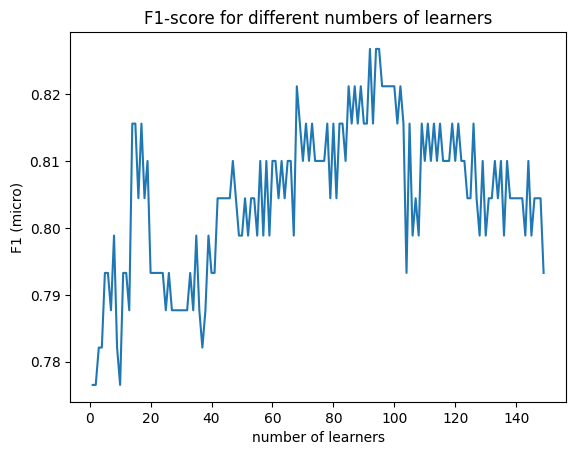

In [8]:
best_adaboost = evaluate_adaboost_for_different_size(train)

In [11]:
test = TitanicDataset('test.csv')
X_test = test.load()

# Ensure X_test is a NumPy array
X_test = np.array(X_test, dtype=float)

# Fill NaN values with 0
X_test[np.isnan(X_test)] = 0
predictions = best_adaboost.predict(X_test)

NaN values before filling: 86
Filling remaining NaNs with median age: 27.0
NaN values after filling: 0


In [12]:
df = pd.DataFrame({
    'PassengerId' : test.passenger_ids , # Store the PassengerId
    'Survived' : predictions
})
df.to_csv('submission.csv', index=False)